# Sparkify Project Workspace

Sparkify is a fictional music streaming service, comparable to Spotify. In this project, a user log of approx. 12 GB is given along with a tiny subset of 128 MB. The entries contain all events created by single users, e.g. by logging in, selecting the next song, or liking a song.

Some users within this event log cancelled their subscription. The goal of this project is to predict for a given trace of user evens whether this user is likely to cancel his subscription and consequently stop to use Sparkify.

In the following notebook, the data is loaded, cleaned, explored, features are extracted and machine learning models are builtt and evaluated. It is basically capabable to be deployed on an AWS EMR cluster.

Requirements to operate on AWS EMR:
- Switch the kernel to 'PySpark' in the Jupyter notebook on AWS EMR
- Install Hive in the AWS EMR environment to support Spark SQL queries
- Open the security group of the master node for outbound HTTPS and outbound HTTP to download pip packages
- Open the security group of the master node for SSH, ssh into it and install the following packages:
    - `sudo env "PATH=$PATH" pip install pytz`
    - also don`t forget to install the pyspark package
    
- Change the security group of the Notebook to allow outbound http traffic [here](https://docs.aws.amazon.com/emr/latest/ManagementGuide/emr-git-repo-open.html) and [here](https://stackoverflow.com/questions/62221521/configuring-emr-notebook-with-github)
- Checkout from git with `!git pull origin master`


- Create an external script and execute via step execution

Todos:
- calculate histograms and plot data in pyspark, not in pandas
- M

In [1]:
%matplotlib inline

In [2]:
# import libraries
#%autoreload

import numpy as np
import pandas as pd

import pyspark as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, regexp_extract
from pyspark.sql.types import FloatType, IntegerType

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. The data is loaded and cleaned. It is checked for missing or invalid data, for example, records without userids or sessionids.

## Load the Dataset

In this example, the file is loaded from a local `.json` file.

In [3]:
# create a Spark session
spark = SparkSession\
        .builder\
        .appName("Sparkify")\
        .getOrCreate()

In [4]:
# load the data in spark
df_s = spark.read.json("mini_sparkify_event_data.json")

In [5]:
df_s.createOrReplaceTempView("df_table")

### Dataset Overview

In [6]:
df_s.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df_s.take(10)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [8]:
df_s.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [9]:
def get_unique_values(table_name, col_name):
    """
    Computes a list of unique values of the given
    table on the given column and returns a list.
    INPUT:
        table_name (str): name of the input table
        col_name (str): name of the column to search unique values
    OUTPUT:
        list (str): all unique values found
    """
    res = spark.sql("""
          SELECT DISTINCT {col_name}
          FROM {table_name}
          """.format(table_name=table_name,
                     col_name=col_name)).show()
    return res

In [10]:
# Print unique values of interesting columns
unique_query_cols = ['page', 'auth', 'level', 'gender']
for col in unique_query_cols:
    res = get_unique_values('df_table', col)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+



## Check for Missing and Invalid Data

### Check for Missing Data

First, columns with missing values are identified.

In [11]:
from pyspark.sql.functions import isnan, when, count, col
df_s.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_s.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



The length value is only defined for `NextSong` events. It reasonable to keep the na value for other events.

## Clean the Data

In the following section data, data columns are cleaned, invalid values are deleted and unnecessary columns are removed.

### Clean the userAgent column

This column contains a lot details that are most likely not relevant. However, the device type / OS type could be relevant, thus we extract it.

In [12]:
# Extract the user system from column `userAgent`
df_table = spark.sql('''
  SELECT *, regexp_extract(userAgent,
                        \"\\\(([a-zA-Z 0-9.]+)\", 1)
                        as userSystem
  FROM df_table
  ''')
df_table.createOrReplaceTempView("df_table")

### Remove empty user names

Login events have no assigned user name. Thus, all `page = Login` events are removed.

In [13]:
df_table = spark.sql("""
                      SELECT *
                      FROM df_table
                      WHERE userId <> ''
                      """)
df_table.createOrReplaceTempView("df_table")

### Delete unnecessary columns

The columns related to the name of the user, name of the listened song and the HTTP method (get/put) are deleted. The assumption is that this information does not affect the decision of a user to cancel its subscription.

In [14]:
df_s = spark.sql('''
                 SELECT userId, page, level, sessionId, ts, gender, itemInSession, userSystem, length, auth
                 FROM df_table
                 ''')
df_s.createOrReplaceTempView("df_table")

# Exploratory Data Analysis

In the following, a small subset of the data is loaded and basic manipulations are done within Spark. Various statistics are evaluated on the provided data in order to derive the right features.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [15]:
"""
Define a column `churn` that is 0 before a `Cancellation Confirmation` and 1 afterwards.

Calculation logic:
- binary encoding of the events
- cumulative sum over the binary encoding
"""
# binary encoding of the 'Cancellation Confirmation' events in column churn
df_s = spark.sql('''
                  SELECT *, CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END as cancel_event
                  FROM df_table
                  ''')
df_s.createOrReplaceTempView('df_table')

In [16]:
# cumulative sum over the churn column to detect phases
df_s = spark.sql('''
          SELECT *,
          SUM(cancel_event) OVER (PARTITION BY userId) as churn
          FROM df_table
          ''')
df_s.createOrReplaceTempView("df_table")

### Store the cleaned and augmented data

In [17]:
df_s.write.parquet("data/preprocessed_data.parquet")

### Get userId of loyal and churned users

Prepare two tables of `userId` separated by the fact whether this is a user that churned or a loyal user. This information is later needed to explore the daa based on the user group.

In [18]:
# Collect all userId of users that cancelled the subscription
cancelled_userIds = spark.sql('''SELECT userId
                                  FROM df_table
                                  GROUP BY userId
                                  HAVING MAX(churn) > 0
                          ''')
cancelled_userIds.createOrReplaceTempView("cancelled_userIds")

# print statistics
print("Overall {} users cancelled their subscription.".format(len(cancelled_userIds.collect())))
cancelled_userIds.write.parquet("data/cancelled_userIds.parquet")

Overall 52 users cancelled their subscription.


In [19]:
# Collect all userId of users that cancelled the subscription
loyal_userIds = spark.sql('''SELECT userId
                                  FROM df_table
                                  GROUP BY userId
                                  HAVING MAX(churn) = 0
                          ''')
loyal_userIds.createOrReplaceTempView("loyal_userIds")

# print statistics
print("Overall {} users did not cancel their subscription.".format(len(loyal_userIds.collect())))
loyal_userIds.write.parquet("data/loyal_userIds.parquet")

Overall 173 users did not cancel their subscription.


### Explore Data

After churn has been defined above, some exploratory data analysis is performed in order to observe the behaviour for users who stayed vs users who churned. The evaluation is based on building aggregates on these two groups of users in order to observe difference in their usage logs.

#### Gender of the user

In the following it is evaluated whether the gender of a user shows correlation to the churn.

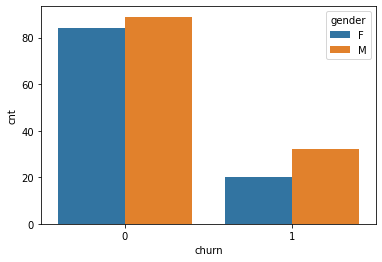

In [20]:
gender_df = spark.sql("""
          SELECT churn, gender, COUNT(gender) as cnt
          FROM (SELECT churn, userId, gender FROM df_table GROUP BY churn, userId, gender)
          GROUP BY churn, gender
          """)
gender_df.write.parquet("data/gender_df.parquet")

sns.barplot(data=gender_df.toPandas(), x='churn', y='cnt', hue='gender')

Even if it seems that the ratio of men is slightly higher among the users that churned, this could be caused by the small number of samples that actually churned.

#### Average length

The `length` event is filled out for `NextSong` and indicates the length of the played song. The listening behaviour could carry information about whether a user might `churn` or not.

In [21]:
# Extract the average length for both groups
lengths_df = spark.sql('''
          SELECT userId, churn, avg(length) as avg_len
          FROM df_table
          GROUP BY userId, churn
          ''')
lengths_df.write.parquet("data/lengths_df.parquet")

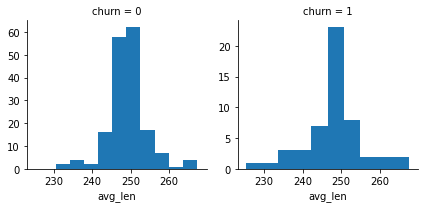

In [22]:
# visualize the distribution of length between two groups of users
g = sns.FacetGrid(lengths_df.toPandas(), col="churn", sharey=False)
g.map(plt.hist, "avg_len");

Both distributions follow a different shape. Thus this feature will be included into the feature extraction process.

#### Items per session

The items per session can carry information about how intensively a user interacts with the portal and also about the session length. This could also contribute to explain the `churn`.

In [23]:
# For each user for each session, extract the average number of items to Pandas
items_per_sess_df = spark.sql('''
          SELECT churn, userId, AVG(itemInSession) as avg
          FROM df_table
          GROUP BY churn, userId
          ''')
items_per_sess_df.write.parquet("data/items_per_sess_df.parquet")

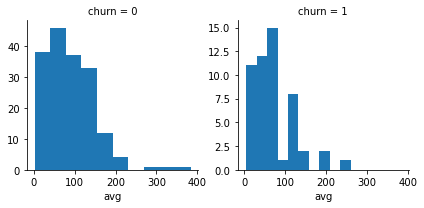

In [24]:
# visualize the distribution of length between two groups of users
g = sns.FacetGrid(items_per_sess_df.toPandas(), col="churn", sharey=False)
g.map(plt.hist, "avg");

The distribution of average events is more skewed for users that churned, indicating that this feature also carries information about a potential `churn`.

#### Average sessions per day

The average sessions per day is counted by dividing the overall session count of a given user by the number of days from the first event observed until the last event observed.

In [25]:
to_days = udf(lambda x: datetime.timedelta(milliseconds=x).days, IntegerType())
spark.udf.register("to_days", to_days)

<function __main__.<lambda>(x)>

In [26]:
# Add the feature for average sessions per day
avg_sess_per_day = """
                   SELECT churn, userId, COUNT(DISTINCT sessionId) / (to_days(MAX(ts) - MIN(ts))+1) as avg_sess_p_day
                   FROM df_table
                   GROUP BY churn, userId
                   """
avg_sess_p_day_df = spark.sql(avg_sess_per_day)
avg_sess_p_day_df.write.parquet("data/avg_sess_p_day_df.parquet")

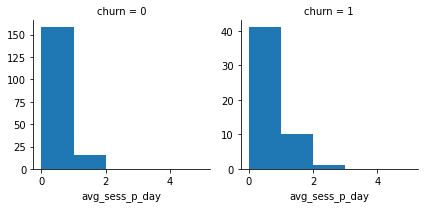

In [27]:
import numpy as np
bins = np.arange(0, 6, 1)

g = sns.FacetGrid(data=avg_sess_p_day_df.toPandas(), col="churn", sharey=False)
g.map(plt.hist, "avg_sess_p_day", bins=bins)

The distribution for churned users tends to have a fatter tail. It can be assumed that this feature also contributes to the classification process.

#### Daytime of service usage

The daytime when the service is used might tell something about the potential of a user to churn. For example, users that frequently use the service in the evening might have a different churn rate than users that rather tend to use the service in the office or during lunch.

In [28]:
to_hour = udf(lambda x: float(datetime.datetime.fromtimestamp(x / 1000.0).hour), FloatType())
spark.udf.register("to_hour", to_hour)

<function __main__.<lambda>(x)>

In [29]:
# Add a column 'hour' to the data based on the timestamp 'ts'
hours_augmented = spark.sql('''
                   SELECT *, to_hour(ts) as hour
                   FROM df_table
                   ''')
hours_augmented.createOrReplaceTempView("df_table_hours")

In [30]:
def get_bucket_percentage(table, time_col, uid_table):
    """
    Returns a Pandas DataFrame which shows for a given user group 
    the percentage of actions during time bucket in column 'col'. This function
    is used to compute the data for loyal and churned users seperately.
    INPUT:
        table (str): name of a table view that contains the 'time_col' column and a 'userId' colummn
        time_col (str): name of the time column, i.e. 'weekday' or 'hour'
        userId_list (str): name of a table that contain a column userId only.
    OUTPUT:
        Pandas DataFrame which shows the total number of events per time bucket for the given user group
    """
    res = spark.sql("""
                    SELECT {time_col}, COUNT({time_col}) / (SELECT COUNT(*) FROM {table} WHERE userId IN (SELECT * FROM {uid_table})) as count 
                    FROM {table}  
                    WHERE userId IN (SELECT * FROM {uid_table})
                    GROUP BY {time_col}
                    ORDER BY count DESC 
                    """.format(uid_table=uid_table, time_col=time_col, table=table))
    res_pd = res.toPandas()
    return res_pd

In [31]:
loyal_hours_pd = get_bucket_percentage('df_table_hours', 'hour', 'loyal_userIds')
churn_hours_pd = get_bucket_percentage('df_table_hours', 'hour', 'cancelled_userIds')

In [32]:
loyal_hours_pd.to_parquet("data/loyal_hours_pd.parquet")
churn_hours_pd.to_parquet("data/churn_hours_pd.parquet")

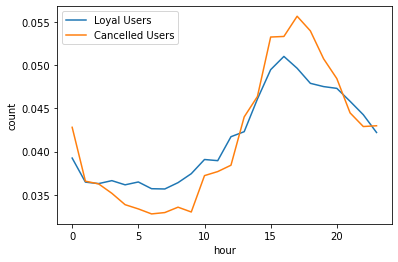

In [33]:
ax = sns.lineplot(x='hour', y='count', data=loyal_hours_pd, label='Loyal Users')
ax = sns.lineplot(x='hour', y='count', data=churn_hours_pd, label='Cancelled Users')
plt.show()

The data shows that `loyal` users are more active during the morning hours and `cancelled` users tend to have a relatively higher activity during the afternoon.

#### Weekday of service usage

The weekday might also play a role to distinguish users that churn from loyal users. For example, users that tend to use the service during workdays might have a different probability to churn than users that use the service during the weekend.

In [34]:
to_day = udf(lambda x: float(datetime.datetime.fromtimestamp(x / 1000.0).weekday()), FloatType())
spark.udf.register("to_day", to_day)

<function __main__.<lambda>(x)>

In [35]:
# Add a column 'weekday' to the data based on the timestamp 'ts'
weekdays_augmented = spark.sql('''
                   SELECT *, to_day(ts) as weekday
                   FROM df_table
                   ''')
weekdays_augmented.createOrReplaceTempView("df_table_weekdays")

In [36]:
loyal_weekdays_pd = get_bucket_percentage('df_table_weekdays', 'weekday', 'loyal_userIds')
churn_weekdays_pd = get_bucket_percentage('df_table_weekdays', 'weekday', 'cancelled_userIds')

In [37]:
loyal_weekdays_pd.to_parquet("loyal_weekdays_pd.parquet")
churn_weekdays_pd.to_parquet("churn_weekdays_pd.parquet")

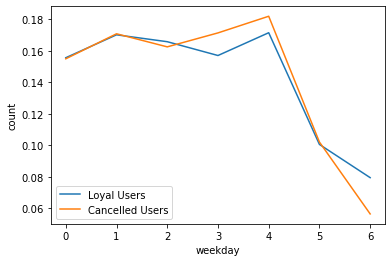

In [38]:
ax = sns.lineplot(x='weekday', y='count', data=loyal_weekdays_pd, label='Loyal Users')
ax = sns.lineplot(x='weekday', y='count', data=churn_weekdays_pd, label='Cancelled Users')
plt.show()

The percentage of usage follows a very similar line, however, cancelled users tend to listen more on Thursday and Friday, while loyal users tend to listen more on Sunday.

#### User system distribution

The type of user agent could play a role with regards to the churn rage, for example if the experience on a smartphone device is worse than on other devices. 

In [39]:
# Compute the most frequently used system for each user
pref_user_system_tbl = spark.sql("""
                            SELECT churn, userId, MAX(userSystem) as pref_user_system
                            FROM df_table
                            GROUP BY churn, userId
                            """)
pref_user_system_tbl.createOrReplaceTempView("pref_user_system_tbl")

In [40]:
# For each useer group, for each system, count the number of users
agg_user_system = spark.sql("""
                            SELECT churn, pref_user_system, 
                            COUNT(*) as cnt
                            FROM pref_user_system_tbl
                            GROUP BY churn, pref_user_system
                            """)
agg_user_system.createOrReplaceTempView("agg_user_system")

In [41]:
# Normalize the user count for each system by the overall number of users in that user group
user_system_perc_df = spark.sql("""
          SELECT churn, pref_user_system, cnt / SUM(cnt) OVER (PARTITION BY churn) as percentage
          FROM agg_user_system
          """)

user_system_perc_df.write.parquet("data/user_system_perc_df.parquet")

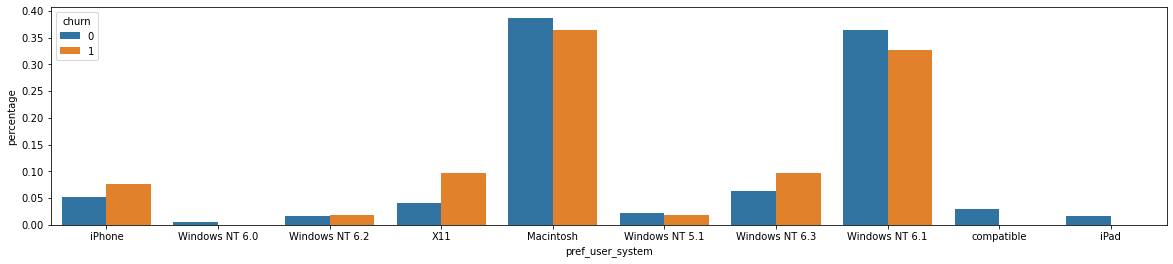

In [42]:
fig = plt.figure(figsize=(20,4))
ax = sns.barplot(x="pref_user_system", y="percentage", hue="churn", data=user_system_perc_df.toPandas())

Loyal users tend to use the iPad, iPad, MacOS, Windows NT 6.1 and compatible more often than users that cancelled. Probably the user experience is better than the desktop app, or people prefer to listen to music en route.

#### Length of the trace

The length of the trace helps to undertand the data. The idea is to compare the first and last timestamp of each user.

In [43]:
# Calculate the account lifetime in days
lifetimes = spark.sql('''
                      SELECT churn, userId, to_days(MAX(ts) - MIN(ts)) as lifetime
                      FROM df_table
                      GROUP BY churn, userId
                      ''')
lifetimes.createOrReplaceTempView("lifetime_table")
lifetimes.write.parquet("data/lifetimes.parquet")

Plot the distribution of account ages (account lifetime):

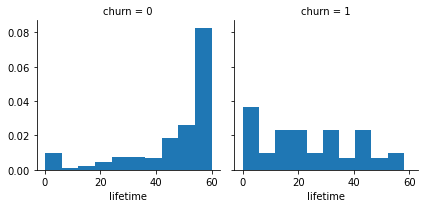

In [44]:
g = sns.FacetGrid(lifetimes.toPandas(), col='churn')
g.map(plt.hist, 'lifetime', density=True)

In [45]:
agg_lifetimes = spark.sql("""
          SELECT churn,
                 AVG(lifetime) as avg,
                 MIN(lifetime) as min,
                 MAX(lifetime) as max
          FROM lifetime_table
          GROUP BY churn
          """)
agg_lifetimes.createOrReplaceTempView("agg_lifetimes")
agg_lifetimes.write.parquet("data/agg_lifetimes.parquet")

In [46]:
agg_lifetimes.toPandas()

,churn,avg,min,max
0,0,46.520231,0,60
1,1,23.134615,0,58


It seems that the cancellation of accounts is uniformely distributed over the lifetime of the account. However, when an account reaches a certain age of e.g. 60 days, it might carry information whether the user will cancel the subscription.

#### Average session duration

It can be assumed that the length of a session depends on the degree of satisfaction with the music service. This is evaluated by analyzing the quartiles of the session length of both user groups.

Sessions have a unique `sessionId`. The strategy is to group by `userId` and then for each `userId`, we group by `sessionId`. Within each session group, the timedelta between the first and the last timestamp describes the session duration. This duration is converted to seconds by a `udf`.

In [47]:
to_minutes = udf(lambda x: int(datetime.timedelta(milliseconds=x).seconds/60.), IntegerType())
spark.udf.register("to_minutes", to_minutes)

<function __main__.<lambda>(x)>

First, the duration of each session is computed and stored in a temp view:

In [48]:
session_lengths = spark.sql('''
                              SELECT churn, userId, sessionId, to_minutes(MAX(ts)-MIN(ts)) as session_duration
                              FROM df_table
                              GROUP BY churn, userId, sessionId
                              ORDER BY userId ASC, MIN(ts) ASC
                              ''')
session_lengths.createOrReplaceTempView("session_lengths")
session_lengths.write.parquet("data/session_lengths.parquet")

Based on this DataFrame, the average session duration for each user group can be analyzed:

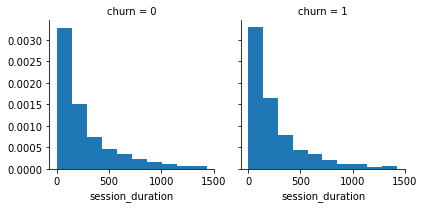

In [49]:
g = sns.FacetGrid(session_lengths.toPandas(), col='churn')
g.map(plt.hist, 'session_duration', density=True)

The distribution of session duration for churned users on the smaller test data has a stronger positive skew.

Based on this, the average, minimum and maximum session length for each user is calculated:

In [50]:
agg_session_lengths = spark.sql("""
          SELECT churn, userId,
                 AVG(session_duration) as avg,
                 MIN(session_duration) as min,
                 MAX(session_duration) as max
          FROM session_lengths
          GROUP BY churn, userId
          """)
agg_session_lengths.createOrReplaceTempView("agg_session_lengths")
agg_session_lengths.write.parquet("data/agg_session_lengths.parquet")

The data is converted to Pandas and melted, in order to be able to create a seaborn plot:

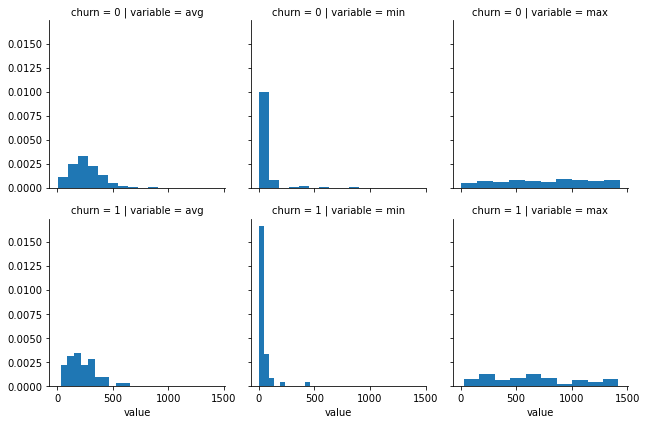

In [51]:
agg_session_lengths_pd = agg_session_lengths.toPandas()
agg_session_lengths_pd_melted = agg_session_lengths_pd.melt(id_vars=['churn', 'userId'])
g = sns.FacetGrid(agg_session_lengths_pd_melted, col='variable', row='churn')
g.map(plt.hist, 'value', density=True)

The upper row shows the average, minimum and maximum session duration for loyal users. The lower row shows these values for churned users. 

The distribution of listening times shows that for 50% of the user base, the group of cancelled users tends to longer session durations. However, the 9-tile shows that loyal users seem to prefer longer listening sessions.

The n-tile distribution of the session lengths for a given user could be a relevant feature to classify the user as `churn`.

#### Payment level

Users change the payment plan over time. The up- or downgrade could give an indication about a likelihood of cancellation. For example, the downgrade to a free usage could be a first indication that the user might delete his account.

In [52]:
up_down_grades = spark.sql('''
                  SELECT *, 
                      CASE WHEN page = 'Submit Upgrade' THEN 1 ELSE 0 END as upgrade_event,
                      CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE 0 END as downgrade_event
                  FROM df_table
                  ''')
up_down_grades.createOrReplaceTempView('up_down_grades')

In [53]:
# cumulative sum over the churn column to detect phases
num_up_down_grades = spark.sql('''
          SELECT *,
              SUM(upgrade_event) OVER (PARTITION BY userId) as num_upgrades,
              SUM(downgrade_event) OVER (PARTITION BY userId) as num_downgrades
          FROM up_down_grades
          ''')
num_up_down_grades.createOrReplaceTempView("num_up_down_grades")

In [54]:
up_downgrades_pd = spark.sql("""
                      SELECT churn, userId, 
                              MAX(num_upgrades) as num_upgrades, 
                              MAX(num_downgrades) as num_downgrades
                      FROM num_up_down_grades
                      GROUP BY churn, userId
                      """).toPandas()

In [55]:
up_downgrades_pd.melt(id_vars=['churn', 'userId'])

,churn,userId,variable,value
0,0,100010,num_upgrades,0
1,0,200002,num_upgrades,1
2,1,125,num_upgrades,0
3,0,124,num_upgrades,0
4,1,51,num_upgrades,0
...,...,...,...,...
445,0,45,num_downgrades,0
446,0,57,num_downgrades,0
447,1,200021,num_downgrades,0
448,0,119,num_downgrades,0


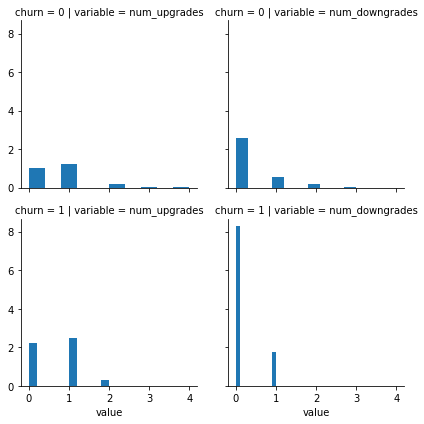

In [56]:
g = sns.FacetGrid(up_downgrades_pd.melt(id_vars=['churn', 'userId']), col='variable', row='churn')
g.map(plt.hist, 'value', density=True)

The left column compares the number of upgrades for both user groups. The up- and downgrade distribution looks similar for both groups

In [57]:
cncl_payment_dist_pd = spark.sql("""
                                  SELECT churn, level, COUNT(level)
                                  FROM df_table
                                  WHERE page = 'Cancellation Confirmation'
                                  GROUP BY churn, level
                                  """).toPandas()

In [58]:
cncl_payment_dist_pd

,churn,level,count(level)
0,1,paid,31
1,1,free,21


#### Average Click-count of pages per session

It can be assumed that loyal users tend to have a different click pattern than users that cancelled. For that, for each page, the average click count over all sessions of a given user group is calculated.

In [59]:
to_month = udf(lambda x: float(datetime.datetime.fromtimestamp(x / 1000.0).month), FloatType())
spark.udf.register("to_month", to_month)

<function __main__.<lambda>(x)>

In [60]:
# Aggregate the count for each page in each session
pages_per_session = spark.sql("""
                              SELECT churn, userId, sessionId, page, COUNT(page) as cnt, to_month(AVG(ts)) as month
                              FROM df_table
                              GROUP BY churn, userId, sessionId, page
                              """)
pages_per_session.createOrReplaceTempView("pages_per_session")

In [61]:
# Average page counts per user per month
tmp = spark.sql("""
          SELECT churn, userId, page, month, AVG(cnt) as avg_cnt
          FROM pages_per_session
          GROUP BY churn, userId, page, month
          """)
tmp.createOrReplaceTempView("tmp")

In [62]:
# Average page counts per user over all months
tmp2 = spark.sql("""
          SELECT churn, userId, page, AVG(avg_cnt) as avg_mhly_cnt
          FROM tmp
          WHERE page <> "NextSong"
          GROUP BY churn, userId, page
          """)
tmp2.createOrReplaceTempView("tmp2")
tmp2.write.parquet("data/avg_page_click_counts.parquet")

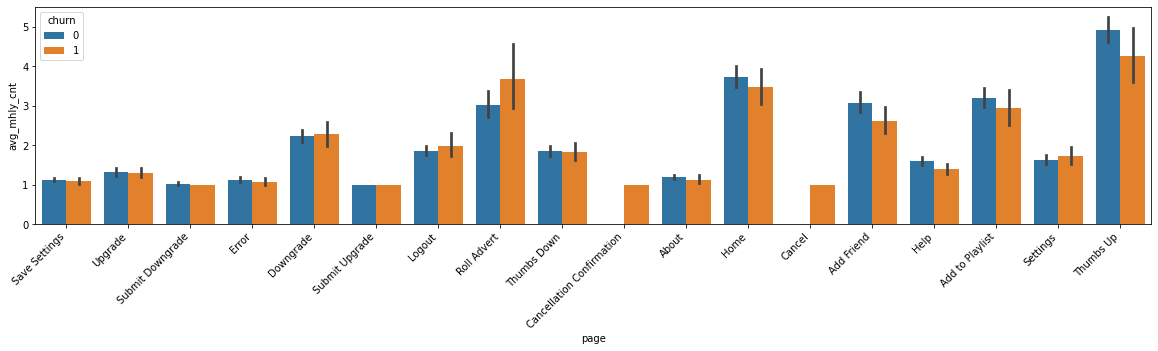

In [63]:
fig = plt.figure(figsize=(20,4))
ax = sns.barplot(x="page", y="avg_mhly_cnt", hue="churn", data=tmp2.toPandas())
plt.xticks(
    rotation=45, 
    horizontalalignment='right' 
)
plt.show()

The average monthly click count for `NextSong` is not shown in this overview, as it is several times larger.

# Feature Engineering

In the following, the features are built out that seem promising to train the model on. The processing steps are stored in an external script. Basically, the following features are extracted

- Average sessions per day
- Average song length
- Average items per session
- Account age
- Average session duration
- Prefered user system as dummy variables
- The average click rate per session for each of the possible pages, except 'Cancellation Confirmation'

In [64]:
%load_ext autoreload
%autoreload 2

from src.ml_features import feature_extraction_pipe
features_df = feature_extraction_pipe(spark)
features_df.write.parquet("data/features_df.parquet")

The script generated the following columns:

In [65]:
features_df.columns

['userId',
 'churn',
 'avg_sess_p_day',
 'avg_length',
 'avg_items_p_sess',
 'acc_age',
 'avg_sess_len',
 'bin_gender',
 'pref_user_system',
 'pref_user_system_ind',
 'pref_user_system_ohe',
 'About',
 'Add_Friend',
 'Add_to_Playlist',
 'Cancel',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll_Advert',
 'Save_Settings',
 'Settings',
 'Submit_Downgrade',
 'Submit_Upgrade',
 'Thumbs_Down',
 'Thumbs_Up',
 'Upgrade']

The resulting DataFrame has the following shape:

In [66]:
print(features_df.count(), len(features_df.columns))

225 29


#### Handling imbalanced classes

The `churn` is highly imbalanced over the provided samples, as the number of loyal users is more than 3 times higher than the number of cancelling users:

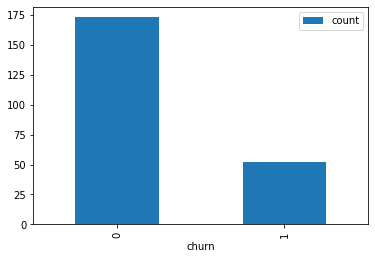

In [67]:
spark.sql("SELECT churn, COUNT(*) as count FROM features_df GROUP BY churn").toPandas().plot.bar(x='churn')

In order to avoid a bias in the classifier, according measures need to be applied. Following choices are considered:
- Define a column `weightCol`, available after Spark 3.0.0
- Up- or Down-sample the classes

As at the time of writing no Docker image for Spark 3.0.0 was available, the approach of up- sampling is applied.

##### Up-sampling underrepresented classes

In order to balance the classses, the positive (`churn` = 1) examples are all used, and the set of negative examples is down-sampled according to the ratio of negative to positive samples.

In [68]:
features_df.createOrReplaceTempView("features_df")

In [69]:
# Extract positive and negative samples
churn_neg_samples = features_df.filter(features_df.churn == 0)
churn_pos_samples = features_df.filter(features_df.churn == 1)

# Compute counts of both sets
churn_neg_cnt = churn_neg_samples.count()
churn_pos_cnt = churn_pos_samples.count()
print("churn_neg_cnt",churn_neg_cnt)
print("churn_pos_cnt",churn_pos_cnt)

churn_neg_cnt 173
churn_pos_cnt 52


In [70]:
# Ratio of positive examples
pos_ratio = (float(churn_pos_cnt) / (churn_neg_cnt))

In [71]:
# Perform the sub-sampling of negative examples
sampled = churn_neg_samples.sample(False, pos_ratio)

In [72]:
# Union sub-sampled negative examples with positive examples
features_df_bal = sampled.union(churn_pos_samples)

In [73]:
# Verify the new number of negative examples
features_df_bal.filter(features_df_bal.churn == 0).count()

55

# Modeling

Before the machine learning model can be selected and trained, the right performance measure for our Sparkify problem needs to be defined:
- Precision: `TP / (TP + FP)` - describes the percentage, when a reported cancelling user really was a cancelling user.
- Recall: `TP / (TP + FN)` - describes the percentage of cancelling users that were correctly detected.
- F1: Harmonic mean between Precision and Recall. Favors such models that have a balanced ratio of Precision and Recall.

In this project, the output of the classificator will be used to place discounts to users in order to avoid their cancellation. The right tradeoff between precision and recall decides between loosing revenue by granting unnecessary discounts or loosing revenue by not properly care for users that might cancel soon.

In case the classifier is tuned to a high recall and low precision, Sparkify would make sure that most of the potentially cancelling users get a discount and probably keep them as users. However, the Sparkify company would waste money due to the low precision, as loyal users are classified as cancelling users more often.

If the classifier is tuned to a low recall and high precision, the Sparkify streaming service could probably miss the timely discount for cancelling users, leading to higher cancellation rates. On the other side, the expenses for unnecessary discounts are reduced, as the detections of cancelling users are more precise.

The final decision largely depends on the pricing model of the company. What discount is needed to convince a customer to stay loyal? What is the monthly revenue generated by a loyal users? These numbers need to be considered when defining the correct threshold. As these details are not clear, in the following, the models are trained to get a balanced recall and precision ratio, thus the `F1` score is used.

First, the data set is split into two parts, a `train_test` set, that is used for 3-fold cross-validation, and a `validation` set. The following models are evaluated:

- Linear Support Vector Machine
- Naive Bayes
- Logistic Regression
- Random Forest

The single models are tuned based on a parameter grid-search and optimized against their `f1` score. The models are evaluated according to the `f1` score and their `accuracy`. The winning model is finally applied to the `validation` set.

For better readability, the code for each model is outsourced to the `src/` subfolder within this repository.

Upfront, the data sets for training and validation are created:

In [75]:
# Split data for training/test and validation
train_test, validation = features_df_bal.randomSplit([0.9, 0.1], seed=42)

In [76]:
train_test.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- avg_sess_p_day: double (nullable = true)
 |-- avg_length: double (nullable = true)
 |-- avg_items_p_sess: double (nullable = true)
 |-- acc_age: integer (nullable = true)
 |-- avg_sess_len: double (nullable = true)
 |-- bin_gender: integer (nullable = true)
 |-- pref_user_system: string (nullable = false)
 |-- pref_user_system_ind: double (nullable = false)
 |-- pref_user_system_ohe: vector (nullable = true)
 |-- About: double (nullable = false)
 |-- Add_Friend: double (nullable = false)
 |-- Add_to_Playlist: double (nullable = false)
 |-- Cancel: double (nullable = false)
 |-- Downgrade: double (nullable = false)
 |-- Error: double (nullable = false)
 |-- Help: double (nullable = false)
 |-- Home: double (nullable = false)
 |-- Logout: double (nullable = false)
 |-- NextSong: double (nullable = false)
 |-- Roll_Advert: double (nullable = false)
 |-- Save_Settings: double (nullable = false)
 |-- Settings

In [77]:
# Check for balanced classes
cncl_rate = train_test.filter((train_test.churn == 1)).count()/train_test.count()
print("The train_test data set contains {}% users that cancelled their subscription.".format(cncl_rate*100.))

The train_test data set contains 47.474747474747474% users that cancelled their subscription.


In [78]:
# Define the features to be used in training
feature_cols = ['avg_sess_p_day',
                 'avg_length',
                 'avg_items_p_sess',
                 'acc_age',
                 'avg_sess_len',
                 'bin_gender',
                 'pref_user_system_ohe',
                 'About',
                 'Add_Friend',
                 'Add_to_Playlist',
                 'Cancel',
                 'Downgrade',
                 'Error',
                 'Help',
                 'Home',
                 'Logout',
                 'NextSong',
                 'Roll_Advert',
                 'Save_Settings',
                 'Settings',
                 'Submit_Downgrade',
                 'Submit_Upgrade',
                 'Thumbs_Down',
                 'Thumbs_Up',
                 'Upgrade']

In [1]:
features_df.fillna(0, subset=feature_cols)

NameError: name 'features_df' is not defined

## Linear Support Vector Machine (SVM)

The used machine learning pipeline is stored in the file `src/ml_pipe_factory.py`.

### SVM Training

In [79]:
# Import various candidate models
%load_ext autoreload
%autoreload 2
from src.ml_pipe_factory import build_svm_pipeline
import pathlib

# Build the SVM pipeline
svm_pipeline = build_svm_pipeline(inputCols = feature_cols)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# Execute the training
svm_model = svm_pipeline.fit(train_test)

In [81]:
# Save the model
model_path = str(pathlib.Path().absolute() / "model" / "svm")
svm_model.bestModel.write().overwrite().save(model_path)

### SVM Evaluation

The SVM model is evaluated in the following cells.

In [108]:
%load_ext autoreload
%autoreload 2
from src.evaluator import evaluate_model
from pyspark.ml import PipelineModel

# Load the model
model_path = str(pathlib.Path().absolute() / "model" / "svm")
svmModel = PipelineModel.load(model_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
# Create predictions
svm_results = svmModel.transform(validation)

# Evaluate the predictions
metrics_svm = evaluate_model(svm_results, "SVM")

metrics_svm

{'model': 'SVM',
 'recall': 0.375,
 'precision': 0.140625,
 'accuracy': 0.375,
 'f1': 0.20454545454545453}

In [110]:
svm_results.filter(svm_results.prediction < 1.0).count()

8

## Naive Bayes Classifier (NB)

### NB Training

In [85]:
# Import various candidate models
from src.ml_pipe_factory import build_naivebayes_pipeline

# Build the NB pipeline
nb_pipeline = build_naivebayes_pipeline(inputCols = feature_cols)

In [86]:
# Execute the training
nb = nb_pipeline.fit(train_test)

In [87]:
# Save the model
nb_path = str(pathlib.Path().absolute() / "model" / "naivebayes")
nb.bestModel.write().overwrite().save(nb_path)

### NB Evaluation

In [111]:
from src.evaluator import evaluate_model
from pyspark.ml import PipelineModel
import pathlib
# Load the model
nbModel = PipelineModel.load(nb_path)

# Create predictions
nb_results = nbModel.transform(validation)

# Evaluate the predictions
metrics_nb = evaluate_model(nb_results, "NaiveBayes")
metrics_nb

{'model': 'NaiveBayes',
 'recall': 1.0,
 'precision': 1.0,
 'accuracy': 1.0,
 'f1': 1.0}

In [112]:
validation.filter(validation.churn == 1).count() / validation.count()

0.625

## Logistic Regression (LR)

### LR Training

In [90]:
# Import various candidate models
from src.ml_pipe_factory import build_logreg_pipeline

# Build the LR pipeline
lr_pipeline = build_logreg_pipeline(inputCols = feature_cols)

In [91]:
# Execute the training
lr = lr_pipeline.fit(train_test)

In [92]:
# Save the model
import pathlib
lr_path = str(pathlib.Path().absolute() / "model" / "logreg")
lr.bestModel.write().overwrite().save(lr_path)

### LR Evaluation

In [113]:
# Load the model
lrModel = PipelineModel.load(lr_path)

# Create predictions
lr_results = lrModel.transform(validation)

# Evaluate the predictions
metrics_lr = evaluate_model(lr_results, "Logistic Regression")
metrics_lr

{'model': 'Logistic Regression',
 'recall': 1.0,
 'precision': 1.0,
 'accuracy': 1.0,
 'f1': 1.0}

## Random Forest (RF)

### RF Training

In [94]:
# Import various candidate models
from src.ml_pipe_factory import build_randomforest_pipeline

# Build the RF pipeline
rf_pipeline = build_randomforest_pipeline(inputCols = feature_cols)

In [95]:
# Execute the training
rf = rf_pipeline.fit(train_test)

In [96]:
# Save the model
import pathlib
rf_path = str(pathlib.Path().absolute() / "model" / "rndmforest")
rf.bestModel.write().overwrite().save(rf_path)

### RF Evaluation

In [114]:
# Load the model
rfModel = PipelineModel.load(rf_path)

# Create predictions
rf_results = rfModel.transform(validation)

# Evaluate the predictions
metrics_rf = evaluate_model(rf_results, "Random Forest")
metrics_rf

{'model': 'Random Forest',
 'recall': 1.0,
 'precision': 1.0,
 'accuracy': 1.0,
 'f1': 1.0}

## Model Evaluation and Validation

The final model’s qualities — such as parameters — are evaluated in detail. Some type of analysis is used to validate the robustness of the model’s solution.

Alternatively a student may choose to answer questions with data visualizations or other means that don't involve machine learning if a different approach best helps them address their question(s) of interest.

In [115]:
metrics_df = pd.DataFrame.from_records([
                                        metrics_svm,
                                        metrics_rf,
                                        metrics_lr,
                                        metrics_nb])

In [116]:
metrics_df_melted = metrics_df.melt(id_vars="model")

In [117]:
metrics_df_melted.rename(columns={'model':"Model",
                                  'variable':"Metric",
                                  'value':"Score"},
                        inplace=True)

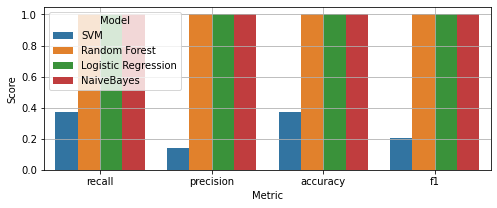

In [118]:
fig = plt.figure(figsize=(8,3))
ax = sns.barplot(x="Metric", y="Score", hue="Model", data=metrics_df_melted)
plt.grid("on")

## Justification
The final results are discussed in detail.
Exploration as to why some techniques worked better than others, or how improvements were made are documented.

# Summary
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

## Reflection
	
Student adequately summarizes the end-to-end problem solution and discusses one or two particular aspects of the project they found interesting or difficult.

## Improvement

Discussion is made as to how at least one aspect of the implementation could be improved. Potential solutions resulting from these improvements are considered and compared/contrasted to the current solution.